STEPS TO THE PROJECT

* DOWNLOAD THE PRETRAINED MODEL FOR SHAPING PREDICTOR
* CREATE A FUNCTION FOR EXTRACTING THE INDEX
* LOAD THE SOURCE AND DESTINATION IMAGE FROM THE INTERNET
* CONVERTING THE IMAGES INTO NUMPY ARRAY
* CONVERTING IMAGE INTO GREYSCALE FOR BETTER RESULTS
* LOAD FACE DETECTOR AND FACE LANDMARKS PREDICTOR
* PERFORM TRIANGULATION ON THE IMAGES TO CUT OUT THE FACE
* CREATING EMPTY MASKS FOR IMAGES
* SWAPPING THE IMAGE FOR THE FACE ON THE DESTINATION IMAGE
* USING SEAMLESS CONE FOR ADJUSTING COLOR SCHEME



# I USED CHAT GPT TO WRITE MOST OF THE CODE

In [ ]:
# Library imports
import cv2
import numpy as np
import dlib
import requests
from PIL import Image
import numpy as np
import seaborn as sns

In [ ]:
# Downloading shape_predictor
!wget 'https://github.com/tzutalin/dlib-android/raw/master/data/shape_predictor_68_face_landmarks.dat'

--2023-08-02 09:17:08--  https://github.com/tzutalin/dlib-android/raw/master/data/shape_predictor_68_face_landmarks.dat
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tzutalin/dlib-android/master/data/shape_predictor_68_face_landmarks.dat [following]
--2023-08-02 09:17:08--  https://raw.githubusercontent.com/tzutalin/dlib-android/master/data/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99693937 (95M) [application/octet-stream]
Saving to: ‘shape_predictor_68_face_landmarks.dat’

shape_predictor_68_ 100%[===================>]  95.08M   189MB/s    in 0.5s  

In [ ]:
# Extracting index from array
def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index

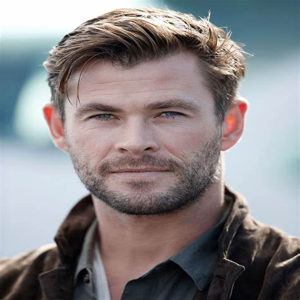

In [ ]:
# Reading source image form url
image1 = Image.open(requests.get('https://th.bing.com/th/id/OIP.cR7k_Y4oG_LMiYUbw8_8KwAAAA?pid=ImgDet&rs=1', stream=True).raw)
image1 = image1.resize((300,300))
image1

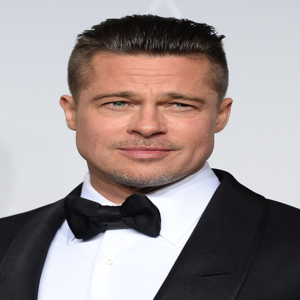

In [ ]:
# Reading destination image form url
image2 = Image.open(requests.get('https://image.tmdb.org/t/p/original/kU3B75TyRiCgE270EyZnHjfivoq.jpg', stream=True).raw)
image2 = image2.resize((300,300))
image2

In [ ]:
# Converting image to array and converting them to grayscale (Data Preprocessing)
img = np.array(image1)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(img_gray)
img2 = np.array(image2)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

In [ ]:
img2_gray

array([[214, 214, 214, ..., 211, 211, 210],
       [214, 214, 214, ..., 211, 211, 210],
       [215, 216, 215, ..., 211, 211, 211],
       ...,
       [ 42,  41,  43, ...,  21,  20,  20],
       [ 38,  43,  45, ...,  20,  20,  21],
       [ 39,  39,  45, ...,  20,  19,  20]], dtype=uint8)

In [ ]:
img2

array([[[208, 213, 219],
        [208, 213, 219],
        [208, 213, 219],
        ...,
        [209, 208, 216],
        [206, 209, 218],
        [205, 208, 216]],

       [[208, 213, 219],
        [208, 213, 219],
        [208, 213, 219],
        ...,
        [206, 209, 216],
        [205, 210, 216],
        [205, 209, 215]],

       [[209, 213, 220],
        [210, 215, 221],
        [209, 214, 220],
        ...,
        [204, 210, 216],
        [208, 209, 215],
        [208, 210, 215]],

       ...,

       [[ 41,  40,  45],
        [ 41,  40,  44],
        [ 42,  42,  44],
        ...,
        [ 19,  20,  24],
        [ 19,  19,  22],
        [ 19,  19,  22]],

       [[ 37,  36,  41],
        [ 43,  42,  46],
        [ 44,  44,  46],
        ...,
        [ 18,  19,  23],
        [ 19,  20,  22],
        [ 19,  21,  22]],

       [[ 38,  38,  42],
        [ 37,  38,  42],
        [ 43,  44,  47],
        ...,
        [ 18,  19,  23],
        [ 17,  19,  21],
        [ 18,  19,  22]]

In [ ]:
# Initalizing frontal face detector and shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
height, width, channels = img2.shape
img2_new_face = np.zeros((height, width, channels), np.uint8)

In [ ]:
# Face 1
faces = detector(img_gray)
for face in faces:
    landmarks = predictor(img_gray, face)
    landmarks_points = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))

    points = np.array(landmarks_points, np.int32)
    convexhull = cv2.convexHull(points)
    cv2.fillConvexPoly(mask, convexhull, 255)

    face_image_1 = cv2.bitwise_and(img, img, mask=mask)

    # Delaunay triangulation
    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    indexes_triangles = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])


        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)

        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)

        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)

        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(triangle)


In [ ]:
# Face 2
faces2 = detector(img2_gray)
for face in faces2:
    landmarks = predictor(img2_gray, face)
    landmarks_points2 = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points2.append((x, y))


    points2 = np.array(landmarks_points2, np.int32)
    convexhull2 = cv2.convexHull(points2)


In [ ]:
# Creating empty mask
lines_space_mask = np.zeros_like(img_gray)
lines_space_new_face = np.zeros_like(img2)

In [ ]:
# Triangulation of both faces
for triangle_index in indexes_triangles:
    # Triangulation of the first face
    tr1_pt1 = landmarks_points[triangle_index[0]]
    tr1_pt2 = landmarks_points[triangle_index[1]]
    tr1_pt3 = landmarks_points[triangle_index[2]]
    triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)


    rect1 = cv2.boundingRect(triangle1)
    (x, y, w, h) = rect1
    cropped_triangle = img[y: y + h, x: x + w]
    cropped_tr1_mask = np.zeros((h, w), np.uint8)


    points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                       [tr1_pt2[0] - x, tr1_pt2[1] - y],
                       [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

    # Lines space
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt2, 255)
    cv2.line(lines_space_mask, tr1_pt2, tr1_pt3, 255)
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt3, 255)
    lines_space = cv2.bitwise_and(img, img, mask=lines_space_mask)

    # Triangulation of second face
    tr2_pt1 = landmarks_points2[triangle_index[0]]
    tr2_pt2 = landmarks_points2[triangle_index[1]]
    tr2_pt3 = landmarks_points2[triangle_index[2]]
    triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)


    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2

    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                        [tr2_pt2[0] - x, tr2_pt2[1] - y],
                        [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

    # Warp triangles
    points = np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)
    warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

    # Reconstructing destination face
    img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area


In [ ]:
# Face swapped (putting 1st face into 2nd face)
img2_face_mask = np.zeros_like(img2_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)


In [ ]:
img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
result = cv2.add(img2_head_noface, img2_new_face)

In [ ]:
# Creating seamless clone of two faces
(x, y, w, h) = cv2.boundingRect(convexhull2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))
seamlessclone = cv2.seamlessClone(result, img2, img2_head_mask, center_face2, cv2.NORMAL_CLONE)

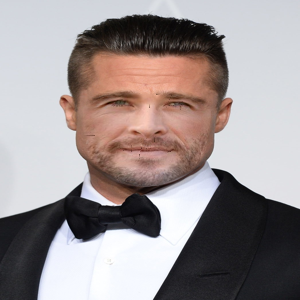

In [ ]:
# Converting array to image
Image.fromarray(seamlessclone)

# what fresh hell did i just make  



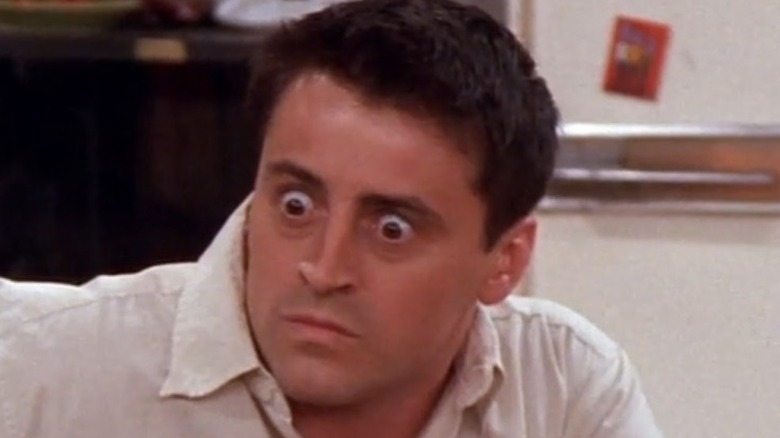